# 단변량 시계열 예측 n-beats model

- 코드출처 : https://github.com/philipperemy/n-beats/tree/master
- 관련논문 : https://arxiv.org/pdf/1905.10437.pdf?trk=public_post_comment-text

- 주식데이터의 시작가로 종가를 예측하는 모형

In [98]:
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch
from keras.optimizers import RMSprop, Adam
import yfinance as yf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time

# 예제 데이터

In [300]:
start_date = '2022-12-31'
end_date ='2024-12-31'

ticker = yf.Ticker('005930.KS')
 
df1= ticker.history(
               interval='1h',
               start=start_date,
               end=end_date,
               actions=True,
               auto_adjust=True)

X = df1.iloc[:,:4].loc[:'2023-11-30 14:00:00+09:00',:]
Y = df1.iloc[:,:4].loc['2023-12-01 10:00:00+09:00':,:]

X, Y = np.log(X),np.log(Y)

In [ ]:
class WINdow:
    def __init__(self,df,timestep):
        self.df = df
        self.timestep=timestep+1 # 예상한 timestep보다 1적기 때문에 +1
        
    def window(self):
        for i in range(1, self.timestep):
            self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
            self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
        window_df = self.df.dropna(axis=0) # 결측치 공간 제거
        self.window_df = window_df.iloc[:,::-1] # 좌우 반전
        
                
        self.feature= self.window_df.iloc[:,:-1].values
        self.y_label= self.window_df.iloc[:,-1].values
        
        return self. window_df 

### train set 

In [327]:
train= X[['Close']]
train1= X[['Open']]
win= WINdow(train,5)
win.window()
win1= WINdow(train1,5)
win1.window()
X_train = win1.feature
y_train = win.y_label

from sklearn.preprocessing import MinMaxScaler, Normalizer

minmax = MinMaxScaler()
norm = Normalizer()
X_train_scale= norm.fit_transform(X_train)
y_train_scale= norm.fit_transform(y_train.reshape(-1, 1) )

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16968\1267832976.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16968\1267832976.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16968\1267832976.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of

### test set

In [328]:
test= Y[['Close']]
test1= Y[['Open']]
wint= WINdow(test,5)
wint.window()
wint1= WINdow(test1,5)
wint1.window()
X_test = wint1.feature
y_test = wint.y_label


X_test_scale= norm.fit_transform(X_test)
y_test_scale= norm.fit_transform(y_test.reshape(-1, 1) )

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16968\1267832976.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16968\1267832976.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16968\1267832976.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of

---

#### model 생성

- nb_blocks_per_stack : stack 안 블락의 갯수
- 각 블락 추출한 theta의 갯수 : (4,4,4)
- input_data_shape = (length, tiemstep, 1)
- 파라미터 셋팅 : loss의 변화가 안정적으로 감소하는 기준으로 셋팅

`-` model
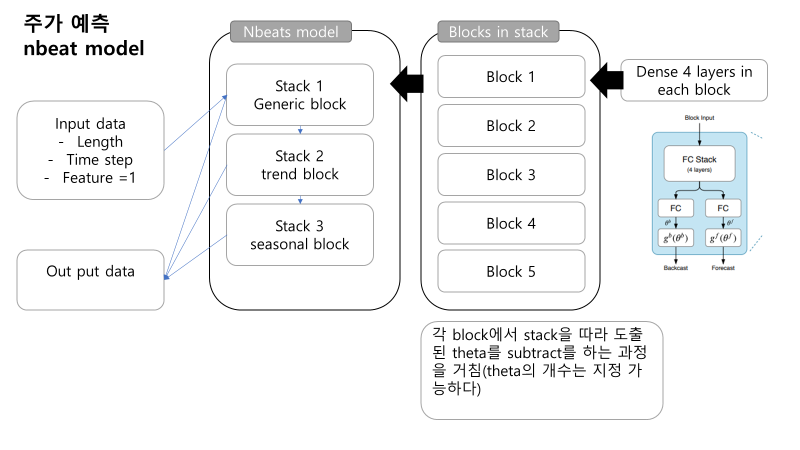

`-` source code
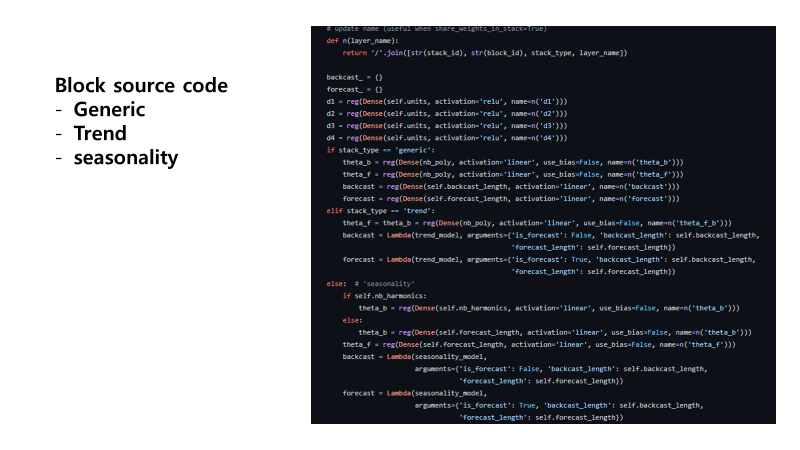
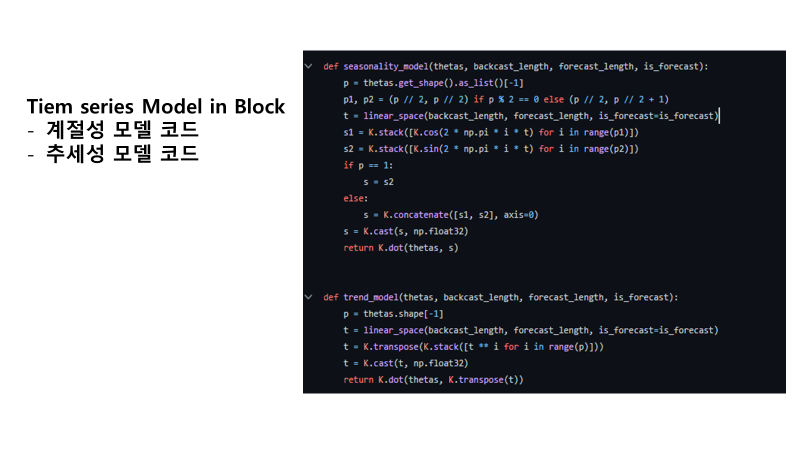

In [348]:
time_steps, input_dim, output_dim = 5, 1, 1
K.clear_session()
model= NBeatsKeras( backcast_length=time_steps, forecast_length=output_dim,
            stack_types=(NBeatsKeras.GENERIC_BLOCK,NBeatsKeras.TREND_BLOCK, NBeatsKeras.SEASONALITY_BLOCK),
            nb_blocks_per_stack=5, thetas_dim=(4,4,4),share_weights_in_stack=True,
            hidden_layer_units=128)
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer )
model.summary()

Model: "forecast"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_variable (InputLayer)    [(None, 5, 1)]       0           []                               
                                                                                                  
 lambda (Lambda)                (None, 5)            0           ['input_variable[0][0]']         
                                                                                                  
 0/0/generic/d1 (Dense)         (None, 128)          768         ['lambda[0][0]',                 
                                                                  'subtract[0][0]',               
                                                                  'subtract_1[0][0]',             
                                                                  'subtract_2[0][0]',      

---

### model fitting

In [349]:
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1, restore_best_weights=True)
#checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
#model.save('best_model.h9')
history = model.fit(X_train_scale,y_train_scale ,
                    validation_data=(X_test_scale, y_test_scale),
                    epochs=50, batch_size=2,callbacks=[early_stop])

Epoch 1/50
675/675 [==============================] - 7s 7ms/step - loss: 0.0146 - val_loss: 1.2700e-09
Epoch 2/50
675/675 [==============================] - 4s 6ms/step - loss: 1.8586e-09 - val_loss: 1.2831e-09
Epoch 3/50
675/675 [==============================] - 4s 6ms/step - loss: 2.1762e-09 - val_loss: 1.7332e-09
Epoch 4/50
675/675 [==============================] - 4s 6ms/step - loss: 2.9603e-09 - val_loss: 1.2333e-09
Epoch 5/50
675/675 [==============================] - 4s 6ms/step - loss: 3.3339e-09 - val_loss: 2.6526e-09
Epoch 5: early stopping


---

### loss

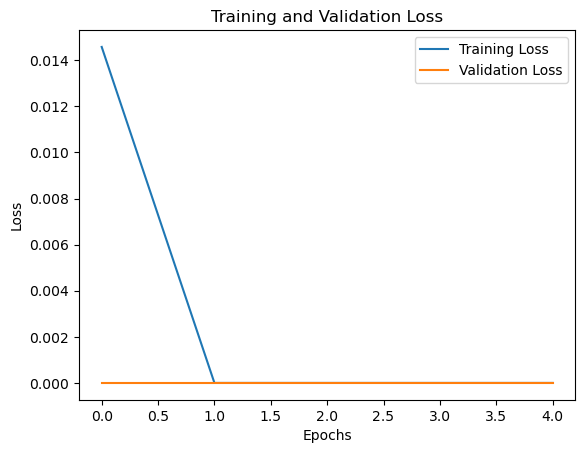

In [350]:
# 훈련과 검증 손실 저장
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

---

### test

In [351]:
pred =model.predict(X_train_scale)
pred1 = model.predict(X_test_scale)

10/10 [==============================] - 0s 3ms/step


In [359]:
from sklearn.metrics import mean_squared_error
mse1= mean_squared_error(np.exp(y_train_scale.flatten()),np.exp(pred.flatten()))
mse2= mean_squared_error(np.exp(y_test_scale.flatten()),np.exp(pred1.flatten()))
print('train MSE{:.10f} '.format(mse1))
print('test MSE{:.10f} '.format(mse2))

train MSE0.0000000104 
test MSE0.0000000095 


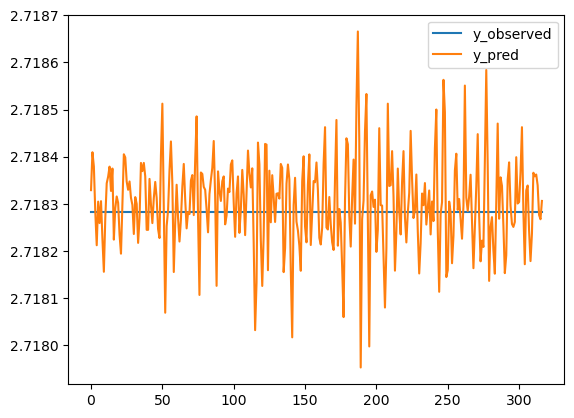

In [360]:
plt.plot(np.exp(y_test_scale.flatten()),label = 'y_observed')
plt.plot(np.exp(pred1.flatten()),label = 'y_pred')
plt.legend()
plt.show()